# 1-D Chemical Explosive Mode Analysis (CEMA) validation (Lu et.al.) for stoichiometric $H_2-air$ combustion ($\phi$ =1) 

Chemical Explosive Mode Analysis (CEMA) has proven to be a useful computational diagnostic tool for analysis combustion data. It can help identify regimes of auto-ignition and flame propagation using an eigen analysis on the chemical Jacobian. Arrhenius.jl can be exploited to perform eigen-analysis thanks to the built in tools for calculating jacobians and eigenvalues/eigenvectors of a matrix. 

In [29]:
using Arrhenius
using LinearAlgebra
using DifferentialEquations
using ForwardDiff
using DiffEqSensitivity
using Sundials
using Plots
using DelimitedFiles
using Profile
cantera_data = readdlm("ct_data.dat")

171×11 Matrix{Float64}:
 0.01      0.295858   0.147929   …  1.97804e-13  0.556213  1001.0
 0.02      0.295858   0.147929      1.0614e-12   0.556213  1001.0
 0.03      0.295858   0.147929      3.31954e-12  0.556213  1001.0
 0.04      0.295858   0.147929      8.50956e-12  0.556213  1001.0
 0.05      0.295858   0.147929      1.98756e-11  0.556213  1001.0
 0.06      0.295858   0.147929   …  4.42671e-11  0.556213  1001.0
 0.07      0.295858   0.147929      9.61617e-11  0.556213  1001.0
 0.08      0.295858   0.147929      2.06229e-10  0.556213  1001.0
 0.09      0.295858   0.147929      4.39757e-10  0.556213  1001.0
 0.1       0.295857   0.147928      9.37095e-10  0.556213  1001.0
 0.11      0.295856   0.147928   …  2.00602e-9   0.556213  1001.01
 0.12      0.295854   0.147926      4.34759e-9   0.556214  1001.01
 0.13      0.29585    0.147923      9.66824e-9   0.556215  1001.03
 ⋮                               ⋱                            ⋮
 0.894688  0.0356073  0.0126109     3.45191e-7   0.

In [31]:
ts= cantera_data[:, 1]
u = cantera_data[:,2:end]
T = cantera_data[:,end]
Y = cantera_data[:,2:end-1]

171×9 Matrix{Float64}:
 0.295858   0.147929   1.67685e-11  …  2.10484e-10  1.97804e-13  0.556213
 0.295858   0.147929   5.47466e-11     6.50633e-10  1.0614e-12   0.556213
 0.295858   0.147929   1.34852e-10     1.57473e-9   3.31954e-12  0.556213
 0.295858   0.147929   3.03816e-10     3.51957e-9   8.50956e-12  0.556213
 0.295858   0.147929   6.60211e-10     7.61734e-9   1.98756e-11  0.556213
 0.295858   0.147929   1.41198e-9   …  1.6256e-8    4.42671e-11  0.556213
 0.295858   0.147929   2.99783e-9      3.44714e-8   9.61617e-11  0.556213
 0.295858   0.147929   6.3437e-9       7.28822e-8   2.06229e-10  0.556213
 0.295858   0.147929   1.34051e-8      1.53871e-7   4.39757e-10  0.556213
 0.295857   0.147928   2.83176e-8      3.24585e-7   9.37095e-10  0.556213
 0.295856   0.147928   5.9854e-8    …  6.84178e-7   2.00602e-9   0.556213
 0.295854   0.147926   1.26739e-7      1.44052e-6   4.34759e-9   0.556214
 0.29585    0.147923   2.69458e-7      3.02627e-6   9.66824e-9   0.556215
 ⋮             

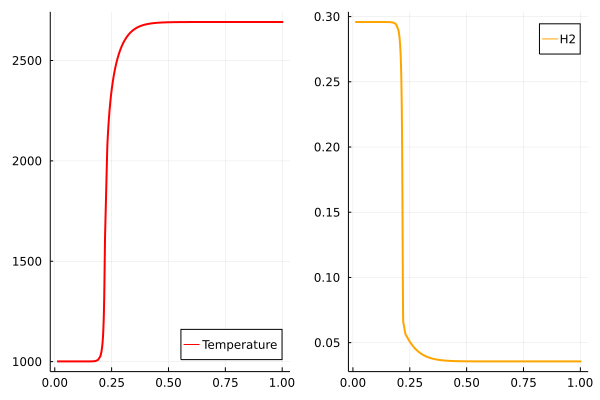

In [32]:
plt1 = plot(ts,T,lw=2,label="Temperature",legend=:bottomright,linecolor = "red")
plt2 = plot(ts,Y[:,1],lw=2,label="H2",legend =:best,linecolor="orange")
plot(plt1,plt2)

In [36]:
gas = CreateSolution("../mechanism/LiDryer.yaml")
P = one_atm
T = 1000
ns = gas.n_species
nr = gas.n_reactions
spec_names = gas.species_names
for i in 1:ns
    print("index ", i," => ",spec_names[i],"\n")
end

index 1 => H2
index 2 => O2
index 3 => O
index 4 => OH
index 5 => H2O
index 6 => H
index 7 => HO2
index 8 => H2O2
index 9 => N2


In [37]:
function dudt(u)
    T = u[end]
    Y = @view(u[1:ns])
    mean_MW = 1. / dot(Y, 1 ./ gas.MW)
    ρ_mass = P / R / T * mean_MW
    X = Y2X(gas, Y, mean_MW)
    C = Y2C(gas, Y, ρ_mass)
    cp_mole, cp_mass = get_cp(gas, T, X, mean_MW)
    h_mole = get_H(gas, T, Y, X)
    S0 = get_S(gas, T, P, X)
    wdot = wdot_func(gas.reaction, T, C, S0, h_mole)
    Ydot = wdot / ρ_mass .* gas.MW
    Tdot = -dot(h_mole, wdot) / ρ_mass / cp_mass
    du = vcat(Ydot, Tdot)
end

dudt (generic function with 1 method)

In [41]:
#compute Jacobian for one
@time J_w = ForwardDiff.jacobian(dudt,u[1,:])

  0.000169 seconds (102 allocations: 45.594 KiB)


10×10 Matrix{Float64}:
 -8.29518e-6   -1.4236e-5    -2.90133e5   …   3.57898e-6  -1.15115e-7
  0.000601601  -0.00173505    0.0300868       6.81274e-5  -1.28866e-6
 -0.000151941   0.000309684  -2.3025e6       -1.54301e-6   1.32556e-7
 -0.000161496   0.000329189   2.44756e6      -1.64839e-6   3.54018e-7
  4.19916e-5   -1.58617e-5   -3.38605e-5     -1.81174e-5   1.93986e-7
  2.372e-5     -3.90892e-5    1.45066e5   …   8.88356e-8   5.18766e-8
 -0.000345645   0.00116539   -0.030487       -5.04583e-5   6.69769e-7
  6.50107e-8   -2.4557e-8    -1.1923e-6      -2.80493e-8   1.57299e-9
  0.0           0.0           0.0             0.0          0.0
 -0.718704      0.446667     -1.65482e8      -0.0725448   -0.00226572

In [46]:
 lambda = eigvals(J_w)

10-element Vector{Float64}:
    -1.3649840528402898e7
    -2.339248624761963e6
 -1281.7349093373377
 -1014.242369146887
    -0.0030068068408325276
    -2.3356973247393255e-6
    -4.567161198433734e-10
     0.0
     4.915698386826457e-9
 10526.224724477977

In [48]:
(lambda_exp,index) = findmax(lambda)

(10526.224724477977, 10)

In [49]:
right_vecs = eigvecs(J_w)

10×10 Matrix{Float64}:
  0.000170858  -0.000361498   5.88285e-5   …   0.000574718  -9.19066e-5
 -8.17434e-6    0.000102412   0.000964555      0.00383013   -0.00116079
  2.00963e-6   -0.00133222    1.09587e-7       4.07793e-14   1.07975e-6
  0.00144242   -0.000284022   5.3767e-8       -1.15539e-14   3.89019e-7
 -0.00152641    0.00175381   -0.000605946     -0.00533396    0.000533834
 -8.56866e-5    0.000183975   9.47585e-7   …  -3.3314e-12    9.38443e-6
  4.98554e-6   -6.24748e-5   -0.00114298       1.46373e-10   0.000668433
 -2.33532e-10   1.70778e-8    0.000724427      3.37723e-10   3.95748e-5
  0.0           0.0           0.0              0.0           0.0
 -0.999998      0.999997     -0.999998        -0.999978      0.999999

In [50]:
a_e = right_vecs[:,index]

10-element Vector{Float64}:
 -9.190658370980618e-5
 -0.0011607883812806672
  1.0797534510935694e-6
  3.8901928168201305e-7
  0.0005338340983246179
  9.384430492797351e-6
  0.0006684328938853956
  3.9574769554508826e-5
  0.0
  0.9999989553427485

In [52]:
left_vecs = inv(eigvecs(J_w))

10×10 Matrix{Float64}:
      6.5555e-9     -1.3354e-8    …      6.68957e-11  -1.64749e-11
     -4.85195e-8     9.85554e-8         -4.87198e-10   3.91395e-11
      6.88239e-5    -0.000670348        -7.99384e-5   -1.37255e-5
     -6.69216e-5     0.000556992         5.81798e-5    1.0395e-5
    155.349        273.753               2.27638       1.09586
  15276.0         1003.7          …   1198.23          0.0956694
  -1077.86          26.3587            -49.5947       -7.73812e-7
      0.0            0.0                 1.94056       0.0
 -14042.9         -756.306           -1144.79          0.000192246
     -4.85132e-5     0.000187584        -2.57503e-6    7.97522e-7

In [55]:
b_e = left_vecs[:,index]

10-element Vector{Float64}:
 -1.6474922337819664e-11
  3.913951714812347e-11
 -1.372545613520515e-5
  1.0394973473992764e-5
  1.0958552265203763
  0.09566936427761297
 -7.73811907217592e-7
  0.0
  0.000192246436911514
  7.975222917622204e-7

In [61]:
EP = a_e.*b_e

10-element Vector{Float64}:
  1.5141538289533787e-15
 -4.543269675447716e-14
 -1.4820108629821165e-11
  4.043845113956244e-12
  0.000585004886743825
  8.978024993533688e-7
 -5.172413324644322e-10
  0.0
  0.0
  7.975214586247751e-7

In [64]:
EI = abs.(EP)/sum(EP)

10-element Vector{Float64}:
 2.580798786423959e-12
 7.743773875932433e-11
 2.5260127230897995e-8
 6.892529915404038e-9
 0.9971113059259952
 0.0015302590506152027
 8.816117474901688e-7
 0.0
 0.0
 0.0013593350775915512

In [69]:
nrow,ncol = size(u)

(171, 10)

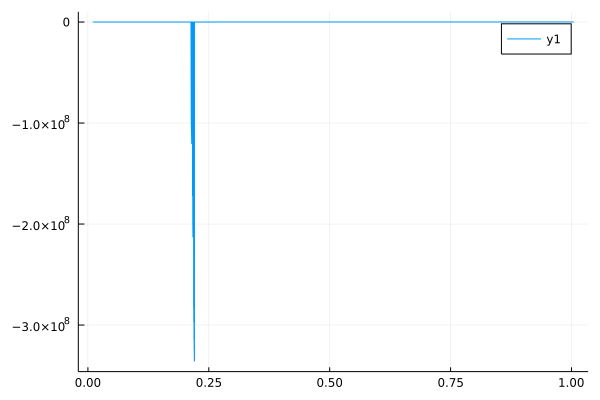

In [88]:
EP = []
EI = []
lambda_exp_arr = zeros(nrow)
for i = 1:nrow
    u_node = u[i,:]
    J_w = ForwardDiff.jacobian(dudt,u_node)
    lambda = eigvals(J_w)
    (lambda_exp,index) = findmax(real(lambda))
    if(all(<=(0),real(lambda)))
        (lambda_exp,index) = findmin(real(lambda))
    end
    lambda_exp_arr[i] = lambda_exp
    right_vecs = eigvecs(J_w)
    a_e = right_vecs[:,index]
    left_vecs = inv(eigvecs(J_w))
    b_e = left_vecs[:,index]
    EP = [EP,a_e.*b_e]
    EI = [EI,abs.(a_e.*b_e)/sum(a_e.*b_e)]
end
plot(ts,lambda_exp_arr)

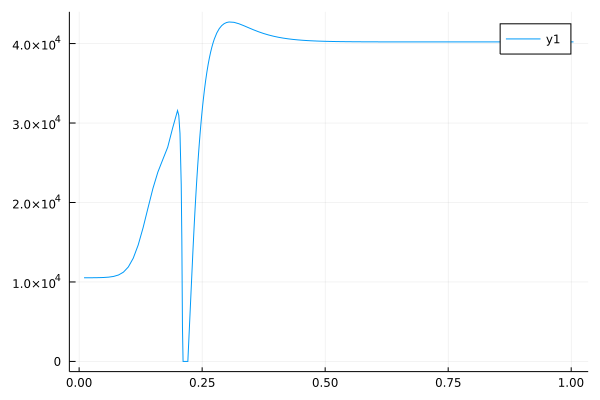

In [94]:
index = findall(x->(x>0),lambda_exp_arr)
t = zeros(length(index));
l = zeros(length(index));
for i =1:length(index)
    t[i] = ts[index[i]]
    l[i] = lambda_exp_arr[index[i]]
end
plot(t,l)